# A/E example notebook

In [1]:
from __future__ import annotations

import argparse
import json
import logging
import os
import pathlib
import pickle as pkl
import warnings
from typing import Callable
import glob

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from legendmeta import LegendMetadata
from legendmeta.catalog import Props
from pygama.pargen.AoE_cal import *  # noqa: F403
from pygama.pargen.AoE_cal import cal_aoe, pol1, sigma_fit, standard_aoe
from pygama.pargen.utils import get_tcm_pulser_ids, load_data

In [2]:
%matplotlib notebook

In [31]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('numba').setLevel(logging.INFO)
logging.getLogger('parse').setLevel(logging.INFO)

## Path to data

### lngs

In [6]:
data_path = "/data2/public_new/prodenv/prod-blind/ref-v1.0.0"

### NERSC

In [5]:
data_path = ""

## Inititalise Metadata

In [7]:
meta  = LegendMetadata(os.path.join(data_path, "inputs"))

## Get files for A/E cal

This is handled by the dataflow in the main production.
For hit tier we just use files for a single run, for the pht tier we use all files for a partition (this is necessary to achieve the statistics for an accurate cut).

### Get Partition runs

In [8]:
run_dict=meta.dataprod.config.partitions.default["01"]
run_dict

{'p03': ['r000', 'r001', 'r002', 'r003', 'r004', 'r005'],
 'p04': ['r000', 'r001', 'r002', 'r003', 'r004']}

### Build file dictionary keyed by first timestamp in run

In [9]:
all_files = {}
all_filelist=[]
for per in list(run_dict):
    for run in run_dict[per]:
        file_path = os.path.join(data_path, f"generated/tier/dsp/cal/{per}/{run}/")
        files = sorted([os.path.join(file_path, file) for file in os.listdir(file_path)])
        all_files[files[0].split("-")[6]] = files
        all_filelist += files

### Choose channel

In [10]:
channel = 'ch1104000'

### Build hit dictionary keyed by first timestamp in run

Here we load in the dictionaries for the calibrations of the different runs these will be updated by our a/e calibration. Again we get a dictionary keyed by the first timestamp in each run - these timestamps will match with the filelist dict above.

In [11]:
all_cal_files = {}
all_cal_dicts={}
for per in list(run_dict):
    for run in run_dict[per]:
        file_path = os.path.join(data_path, f"generated/par/pht/cal/{per}/{run}/*-par_pht.json")
        file = glob.glob(file_path)[0]
        cal_dict = Props.read_from(file)
            
        # get dict for channel
        chan_dict = cal_dict[channel]["pars"]["operations"]
        
        #remove AoE fields
        aoe_keys = []
        for key in chan_dict:
            if "AoE" in key:
                aoe_keys.append(key)
        for key in aoe_keys:
            chan_dict.pop(key)
                
        all_cal_dicts[file.split("-")[6]] = chan_dict
        all_cal_files[file.split("-")[6]] = file

In [12]:
all_cal_dicts

{'20230311T235840Z': {'cuspEmax_ctc': {'expression': 'cuspEmax*(1+dt_eff*a)',
   'parameters': {'a': 5.62e-07}},
  'cuspEftp_ctc': {'expression': 'cuspEftp*(1+dt_eff*a)',
   'parameters': {'a': 5.62e-07}},
  'zacEmax_ctc': {'expression': 'zacEmax*(1+dt_eff*a)',
   'parameters': {'a': 5.75e-07}},
  'zacEftp_ctc': {'expression': 'zacEftp*(1+dt_eff*a)',
   'parameters': {'a': 5.75e-07}},
  'trapEmax_ctc': {'expression': 'trapEmax*(1+dt_eff*a)',
   'parameters': {'a': 5.56e-07}},
  'trapEftp_ctc': {'expression': 'trapEftp*(1+dt_eff*a)',
   'parameters': {'a': 5.56e-07}},
  'tailEmax_cut': {'expression': '(a<(tailEmax))&((tailEmax)<b)',
   'parameters': {'a': 6.0739, 'b': 26.5271}},
  'baselineEmax_cut': {'expression': '(a<(baselineEmax))&((baselineEmax)<b)',
   'parameters': {'a': 4.7043, 'b': 26.2753}},
  'bl_slope_cut': {'expression': '(a<(bl_slope))&((bl_slope)<b)',
   'parameters': {'a': -0.0759, 'b': 0.0755}},
  'bl_std_cut': {'expression': '(a<(bl_std))&((bl_std)<b)',
   'parameters'

### Load in energy resolution curve for channel

get energy resolution for partition

In [13]:
eres_dict = all_cal_files[iter(all_cal_files).__next__()]
eres = Props.read_from(eres_dict)

In [14]:
eres = eres[channel]["results"]["partition_ecal"]["cuspEmax_ctc_cal"]["eres_linear"]

In [15]:
def eres_func(x):
    return eval(eres["expression"], dict(x=x, **eres["parameters"]))

## Load Metadata

Metadata is channel specific but generally is the same within a detector type

In [16]:
kwarg_dict = Props.read_from(meta.dataprod.config.on(iter(all_cal_files).__next__(), system="cal").snakemake_rules.pars_pht_aoecal.inputs.par_pht_aoecal_config[channel])


In [17]:
kwarg_dict.pop("run_aoe")

True

This dict contains the parameters for running the a/e as well as the plots to be generated after

In [18]:
print(json.dumps(kwarg_dict, indent=4))

{
    "pulser_multiplicity_threshold": 5,
    "final_cut_field": "is_valid_cal",
    "threshold": 800,
    "current_param": "A_max",
    "energy_param": "cuspEmax",
    "cal_energy_param": "cuspEmax_ctc_cal",
    "dt_corr": true,
    "dt_param": "dt_eff",
    "mean_func": "pol1",
    "sigma_func": "sigma_fit",
    "high_cut_val": 3,
    "plot_options": {
        "spectrum": {
            "function": "plot_spectra",
            "options": null
        },
        "sf_v_energy": {
            "function": "plot_sf_vs_energy",
            "options": null
        },
        "survival_fractions": {
            "function": "plot_survival_fraction_curves",
            "options": null
        },
        "cut_fit": {
            "function": "plot_cut_fit",
            "options": null
        },
        "classifier": {
            "function": "plot_classifier",
            "options": null
        },
        "sigma_fit": {
            "function": "plot_sigma_fit",
            "options": null
      

## Load in the data for the A/E calibration

Use load data from pargen.utils, this handles applying the hit dicts to the data to define quality cuts and energy calibration. We use a threshold normally of 900 keV to minimise amount of data held in memory

In [19]:
params = [
        kwarg_dict["final_cut_field"],
        kwarg_dict["current_param"],
        "tp_0_est",
        "tp_99",
        kwarg_dict["energy_param"],
        kwarg_dict["cal_energy_param"],
        "timestamp",
    ]
if "dt_param" in kwarg_dict:
    params.append(kwarg_dict["dt_param"])
else:
    params.append("dt_eff")

This will take a while as a lot of data is being loaded

In [20]:
data, threshold_mask = load_data(
    all_files,
    f"{channel}/dsp",
    all_cal_dicts,
    params=params,
    threshold=kwarg_dict.pop("threshold"),
    return_selection_mask=True,
)

In [21]:
display(data)

,A_max,cuspEmax,cuspEmax_ctc,cuspEmax_ctc_cal,dt_eff,is_valid_cal,timestamp,tp_0_est,tp_99,run_timestamp
1,1034.781252,13982.591797,13989.868039,2163.512169,925.940692,True,1.678579e+09,47696.0,48880.0,20230311T235840Z
4,443.430230,10836.965820,10843.381981,1677.105063,1053.491855,True,1.678579e+09,47440.0,51648.0,20230311T235840Z
6,324.097742,5320.591797,5322.115729,822.959951,509.646966,True,1.678579e+09,48096.0,49168.0,20230311T235840Z
16,717.840468,9606.835938,9610.803905,1486.493314,734.939153,True,1.678579e+09,47888.0,48864.0,20230311T235840Z
32,954.185628,15431.653320,15434.295111,2386.715532,304.613802,True,1.678579e+09,48304.0,49904.0,20230311T235840Z
...,...,...,...,...,...,...,...,...,...,...
262869,839.554718,11367.306641,11372.935935,1759.006423,881.170691,True,1.683146e+09,47728.0,48848.0,20230503T162448Z
262872,607.080206,8248.960938,8252.162929,1276.336807,690.692361,True,1.683146e+09,47920.0,48864.0,20230503T162448Z
262877,333.316774,7213.754883,7214.384262,1115.783471,155.243996,True,1.683146e+09,48560.0,49248.0,20230503T162448Z
262881,323.058682,6128.727539,6131.459386,948.220682,793.139659,True,1.683146e+09,47824.0,48960.0,20230503T162448Z


## Pulser removal

There are plenty of ways to handle pulser removal, the version shown here uses the tcms as is done in the legend dataflow, an alternative is to use find_pulser_properties in pygama.pargen.cuts and then cut around the pulser peak

In [22]:
# define tcm_filelists
tcm_files = [file.replace("dsp", "tcm") for file in all_filelist]

In [23]:
tcm_files = sorted(np.unique(tcm_files))
ids, mask = get_tcm_pulser_ids(
    tcm_files, channel, kwarg_dict.pop("pulser_multiplicity_threshold")
)
data["is_pulser"] = mask[threshold_mask]

<IPython.core.display.Javascript object>


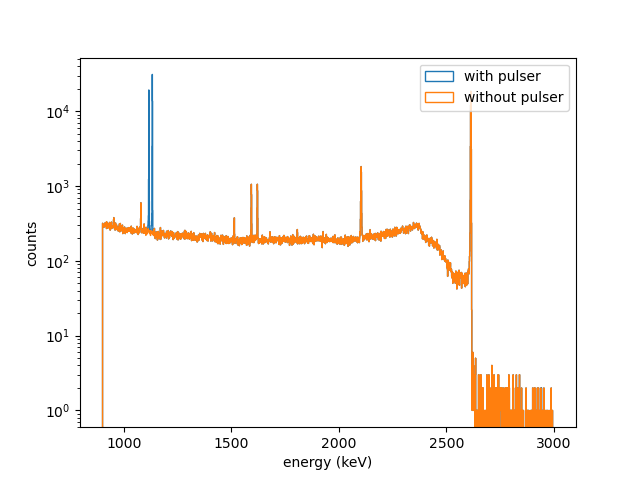

In [24]:
plt.figure()
plt.hist(data["cuspEmax_ctc_cal"], bins=np.arange(900,3000,1), histtype="step", label="with pulser")
plt.hist(data.query("~is_pulser")["cuspEmax_ctc_cal"], bins=np.arange(900,3000,1), 
         histtype="step", label="without pulser")
plt.legend()
plt.xlabel("energy (keV)")
plt.ylabel("counts")
plt.yscale("log")
plt.show()

## A/E Calibration

In [25]:
# get needed functions from metadata
pdf = eval(kwarg_dict.pop("pdf")) if "pdf" in kwarg_dict else standard_aoe

mean_func = eval(kwarg_dict.pop("mean_func")) if "mean_func" in kwarg_dict else pol1

if "sigma_func" in kwarg_dict:
    sigma_func = eval(kwarg_dict.pop("sigma_func"))
else:
    sigma_func = sigma_fit

In [26]:
# eval plot funcs
if "plot_options" in kwarg_dict:
    for field, item in kwarg_dict["plot_options"].items():
        kwarg_dict["plot_options"][field]["function"] = eval(item["function"])

In [27]:
def aoe_calibration(
    data: pd.Dataframe,
    cal_dicts: dict,
    current_param: str,
    energy_param: str,
    cal_energy_param: str,
    eres_func: Callable,
    pdf: Callable = standard_aoe,
    selection_string: str = "",
    dt_corr: bool = False,
    dep_correct: bool = False,
    dt_cut: dict | None = None,
    high_cut_val: int = 3,
    mean_func: Callable = pol1,
    sigma_func: Callable = sigma_fit,
    dep_acc: float = 0.9,
    dt_param: str = "dt_eff",
    comptBands_width: int = 20,
    plot_options: dict | None = None,
):
    data["AoE_Uncorr"] = data[current_param] / data[energy_param]
    aoe = cal_aoe(
        cal_dicts,
        cal_energy_param,
        eres_func,
        pdf,
        selection_string,
        dt_corr,
        dep_acc,
        dep_correct,
        dt_cut,
        dt_param,
        high_cut_val,
        mean_func,
        sigma_func,
        comptBands_width,
        plot_options if plot_options is not None else {},
    )
    aoe.update_cal_dicts(
        {
            "AoE_Uncorr": {
                "expression": f"{current_param}/{energy_param}",
                "parameters": {},
            }
        }
    )
    aoe.calibrate(data, "AoE_Uncorr")
    log.info("Calibrated A/E")
    return cal_dicts, aoe.get_results_dict(), aoe.fill_plot_dict(data), aoe

INFO:pygama.pargen.AoE_cal:Starting A/E time correction
INFO:pygama.pargen.AoE_cal:A/E time correction finished
INFO:pygama.pargen.AoE_cal:Finished A/E time correction
INFO:pygama.pargen.AoE_cal:Starting A/E drift time correction
INFO:pygama.pargen.AoE_cal:dtcorr successful alpha:6.510871266021664e-06
INFO:pygama.pargen.AoE_cal:Starting A/E energy correction
INFO:pygama.pargen.AoE_cal:60 compton bands fit successfully
INFO:pygama.pargen.AoE_cal:Finished A/E energy successful
INFO:pygama.pargen.AoE_cal:mean pars are {'a': -2.997460168413461e-06, 'b': 1.007942518634376}
INFO:pygama.pargen.AoE_cal:sigma pars are {'a': 3.044497145707703e-05, 'b': 28.406215367161323, 'c': 2.553739663741218}
INFO:pygama.pargen.AoE_cal:Starting A/E low cut determination
INFO:pygama.pargen.AoE_cal:Cut found at -1.62
INFO:pygama.pargen.AoE_cal:  Compute low side survival fractions: 
INFO:pygama.pargen.AoE_cal:1592.5keV: 90.2 +/- 3.4 %
INFO:pygama.pargen.AoE_cal:1620.5keV: 10.4 +/- 1.1 %
INFO:pygama.pargen.AoE_c

<IPython.core.display.Javascript object>


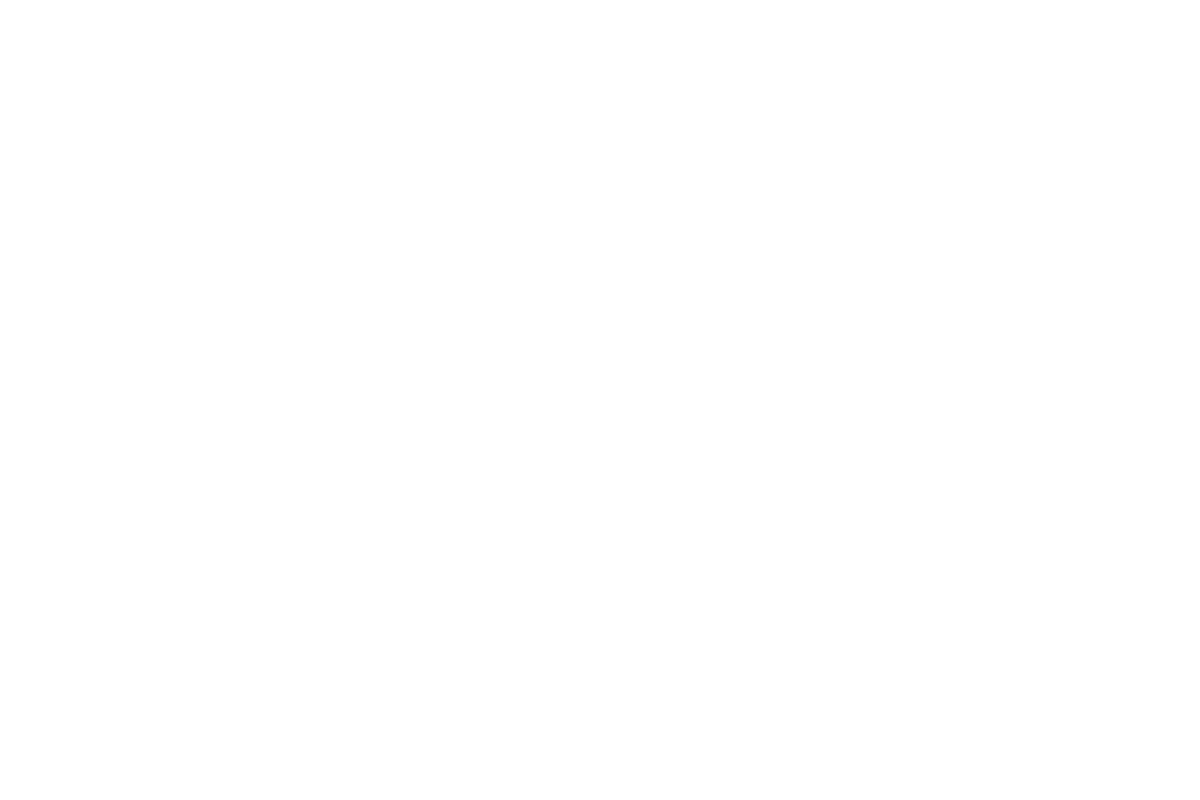

<IPython.core.display.Javascript object>


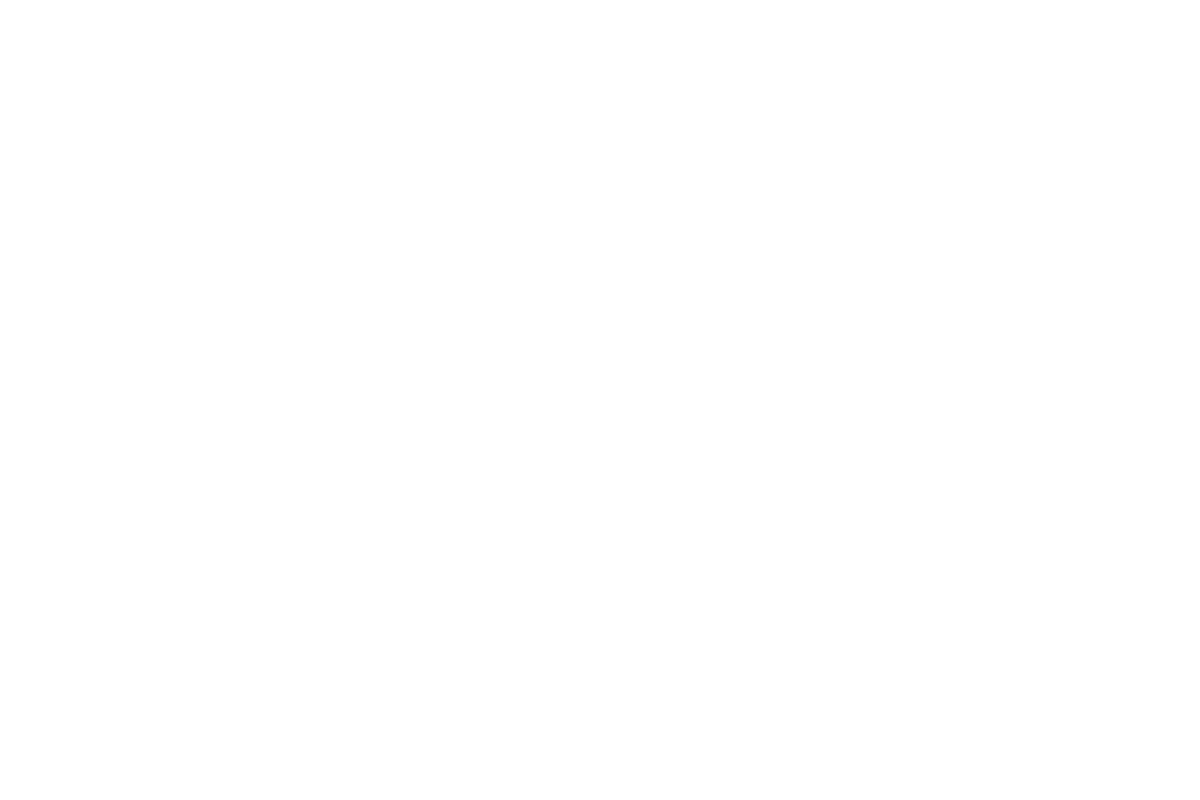

<IPython.core.display.Javascript object>


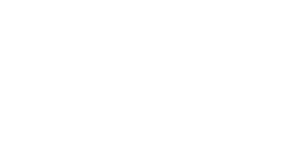

<IPython.core.display.Javascript object>


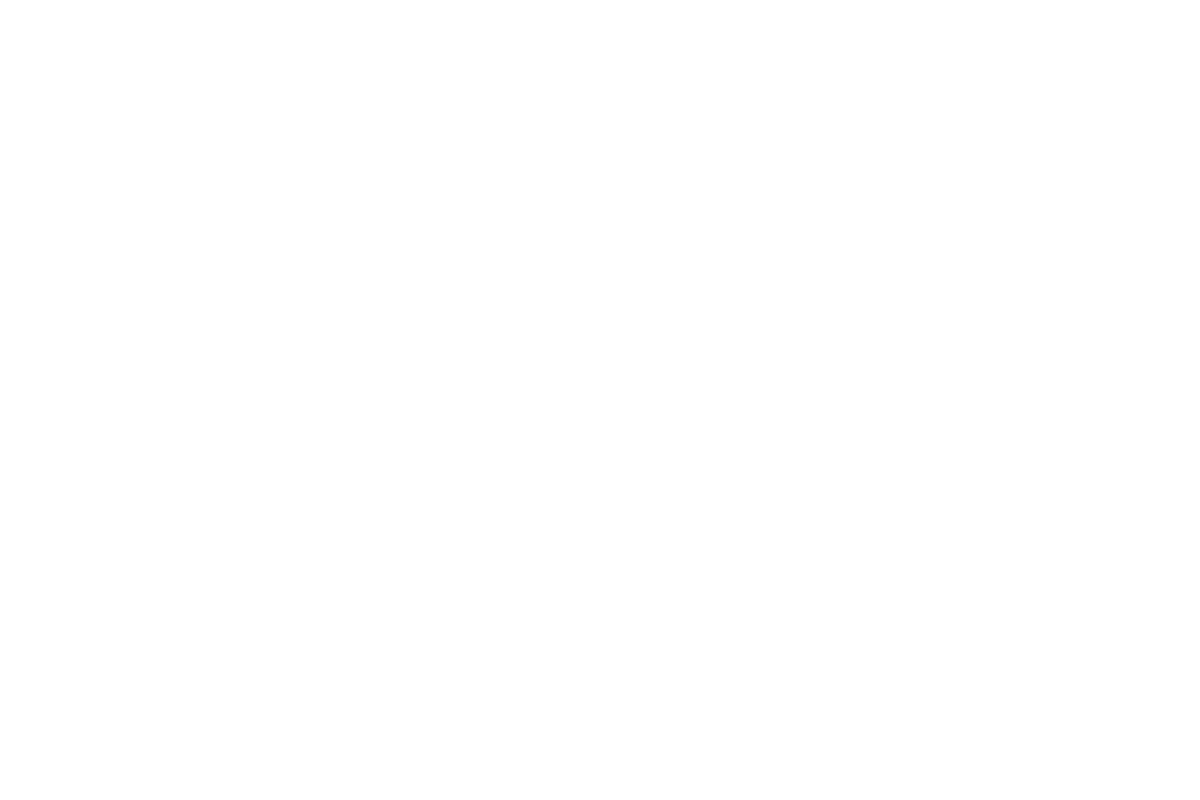

<IPython.core.display.Javascript object>


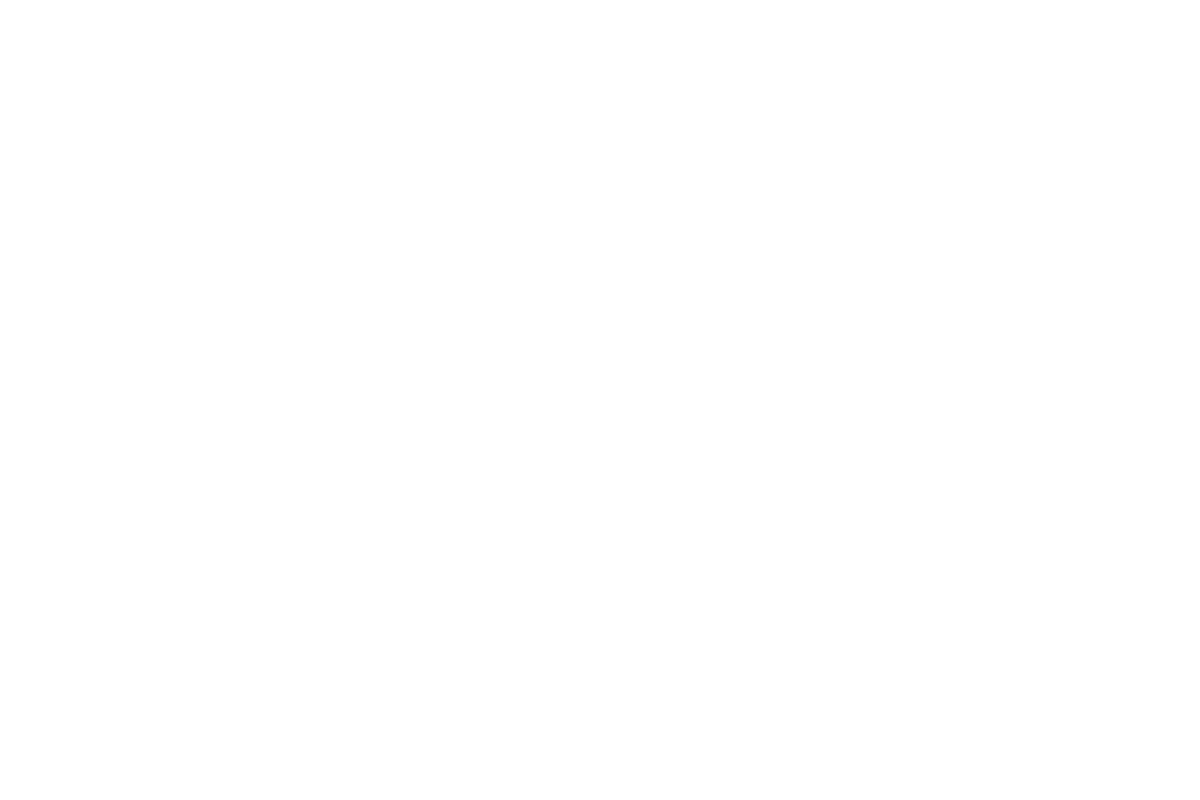

<IPython.core.display.Javascript object>


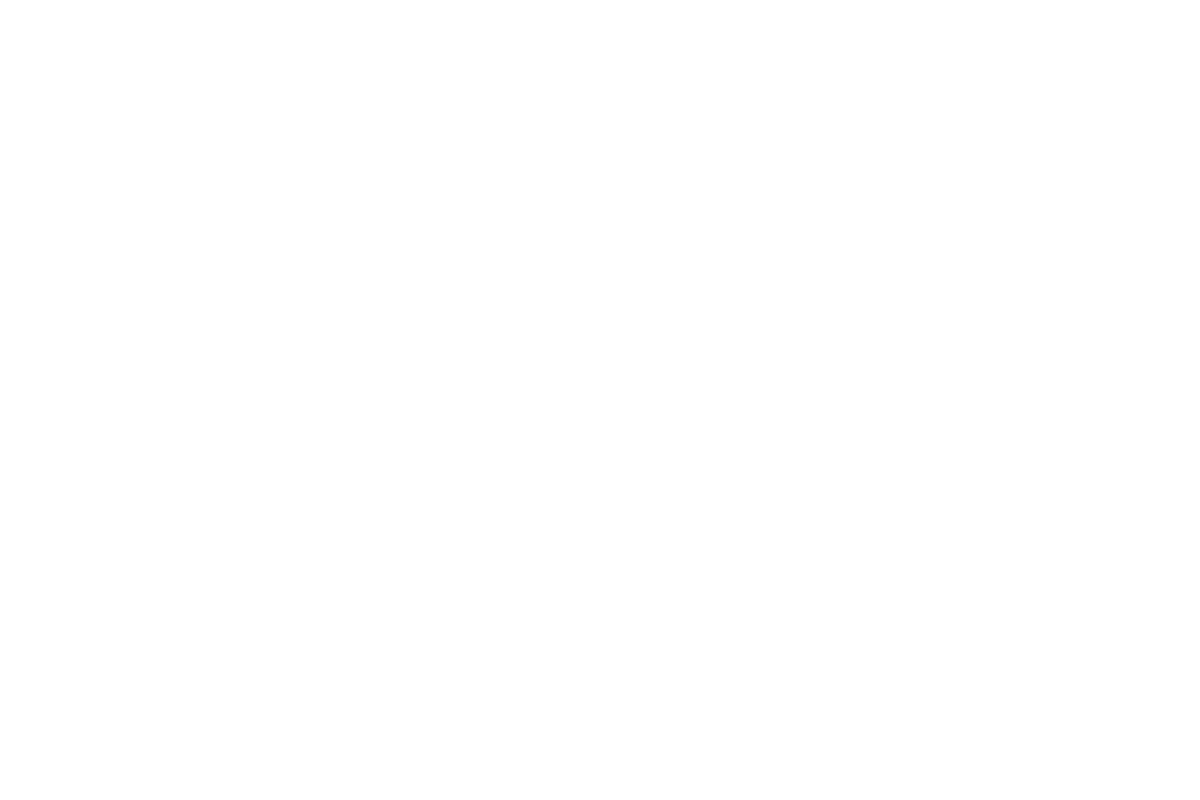

<IPython.core.display.Javascript object>


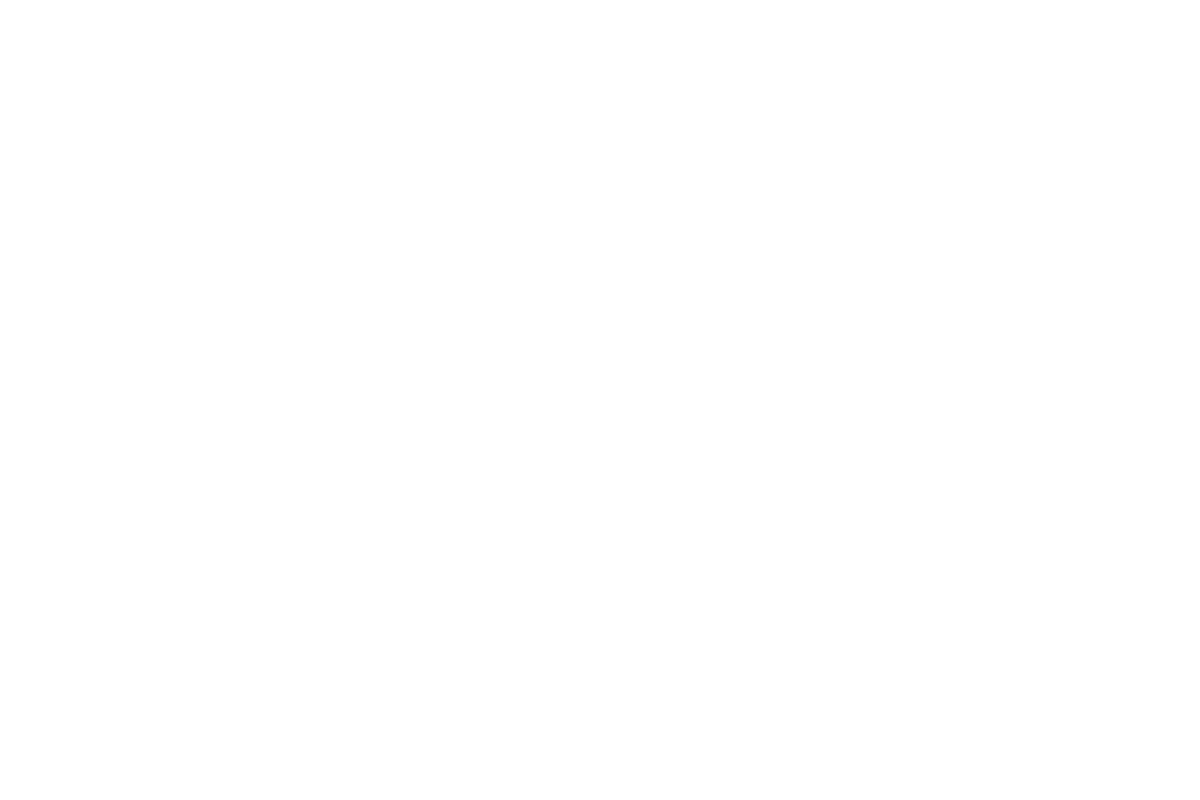

<IPython.core.display.Javascript object>


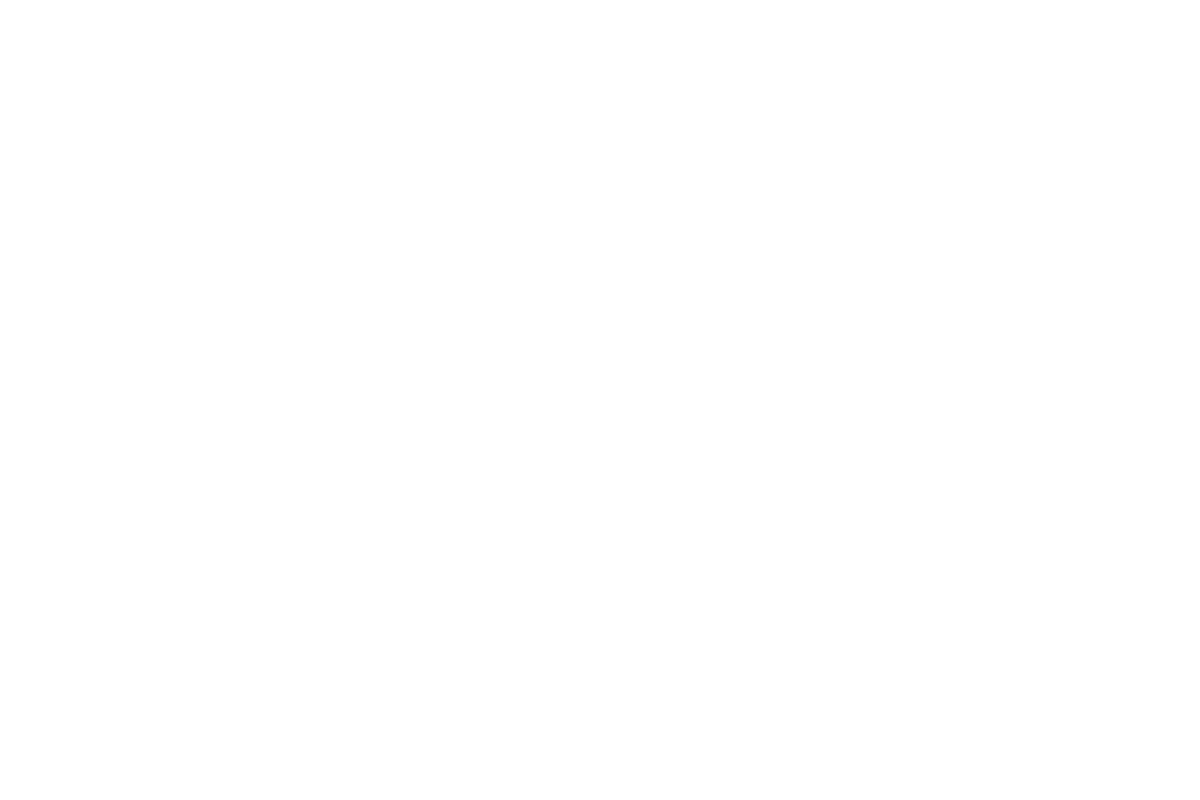

<IPython.core.display.Javascript object>


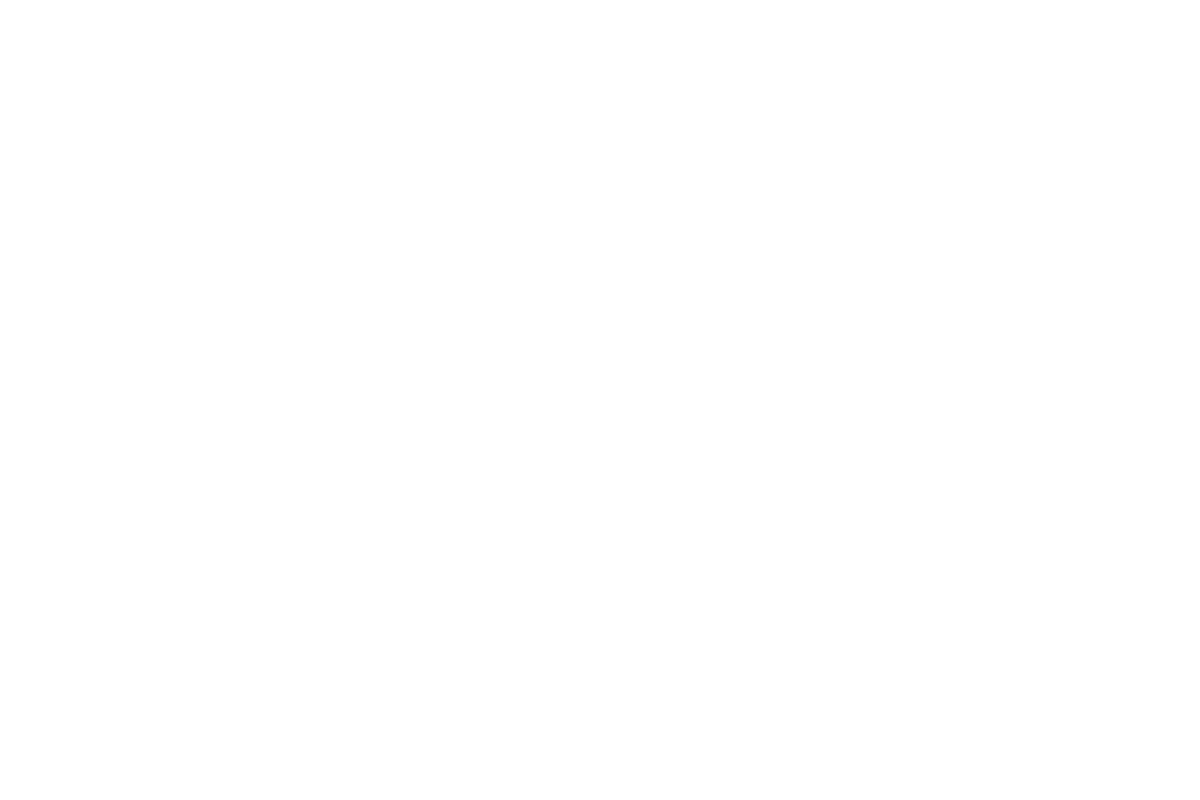

<IPython.core.display.Javascript object>


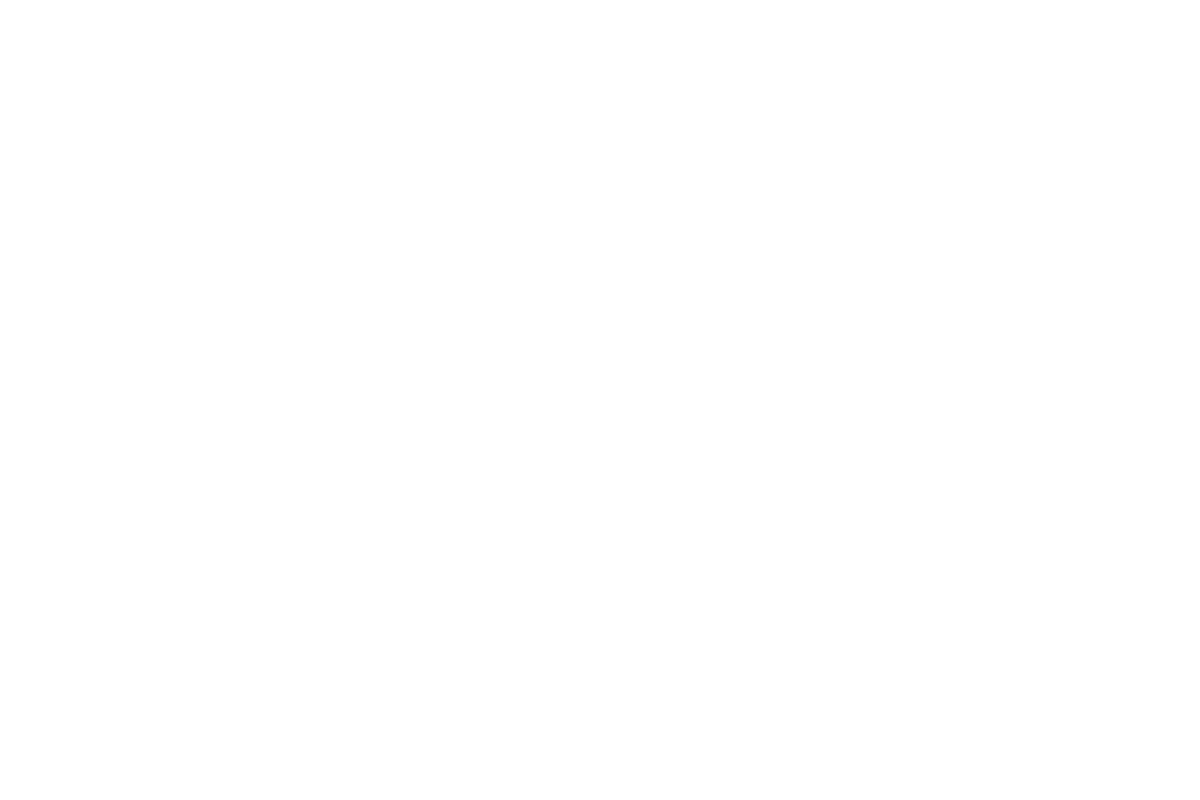

<IPython.core.display.Javascript object>


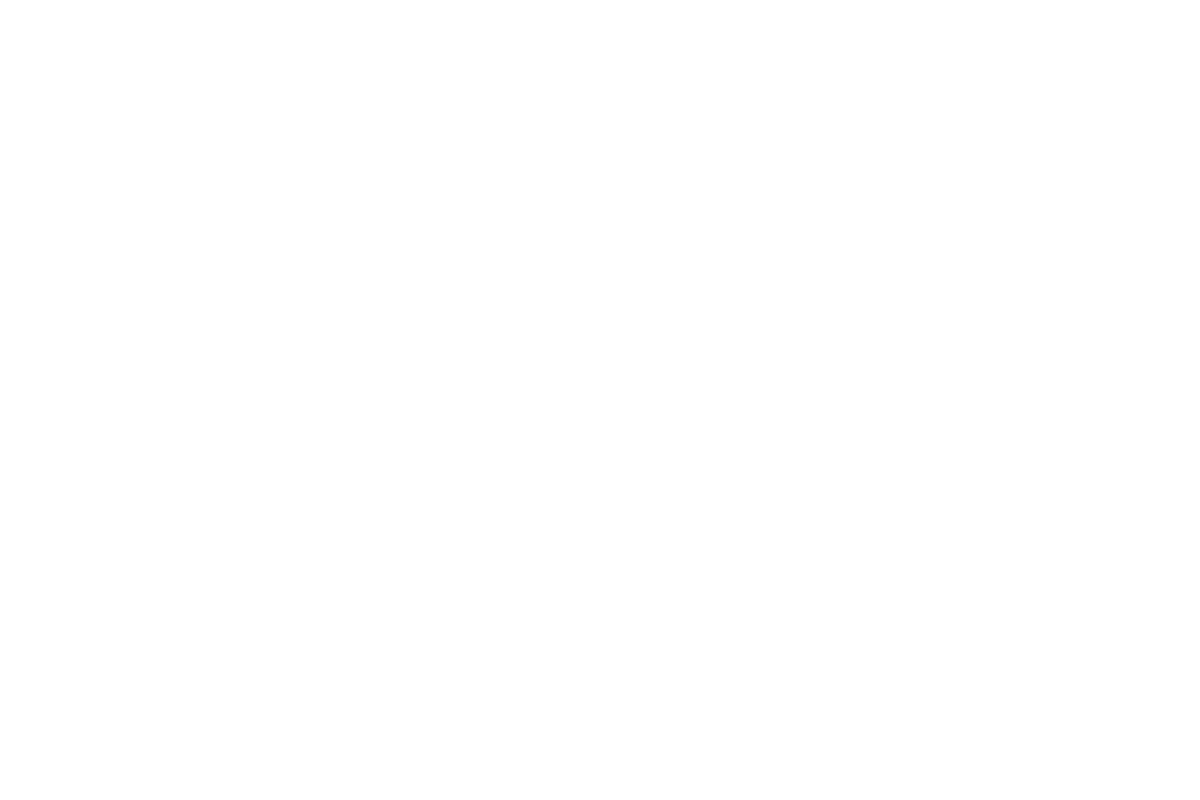

<IPython.core.display.Javascript object>


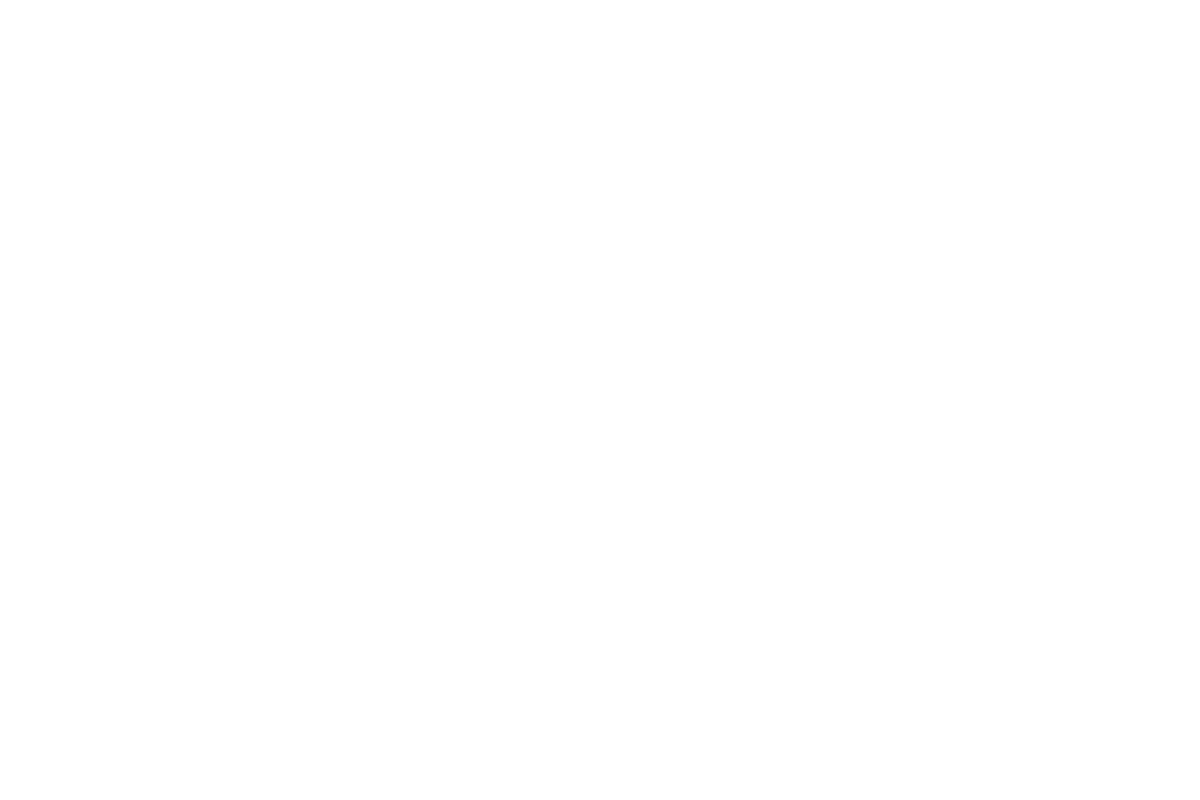

<IPython.core.display.Javascript object>


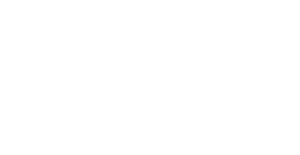

In [28]:
# run A/E calibration
cal_dict, out_dict, plot_dict, aoe_obj = aoe_calibration(
    data,
    selection_string=f"{kwarg_dict.pop('final_cut_field')}&(~is_pulser)",
    cal_dicts=cal_dict,
    eres_func=eres_func,
    pdf=pdf,
    mean_func=mean_func,
    sigma_func=sigma_func,
    **kwarg_dict,
)

## Output plots

In [29]:
plot_dict.keys()

dict_keys(['spectrum', 'sf_v_energy', 'survival_fractions', 'cut_fit', 'classifier', 'sigma_fit', 'mean_fit', 'plot_dt_dep', 'compt_bands_corrected', 'compt_bands_uncorrected', 'drift_time_correction', 'mean_time', 'res_time'])

<IPython.core.display.Javascript object>


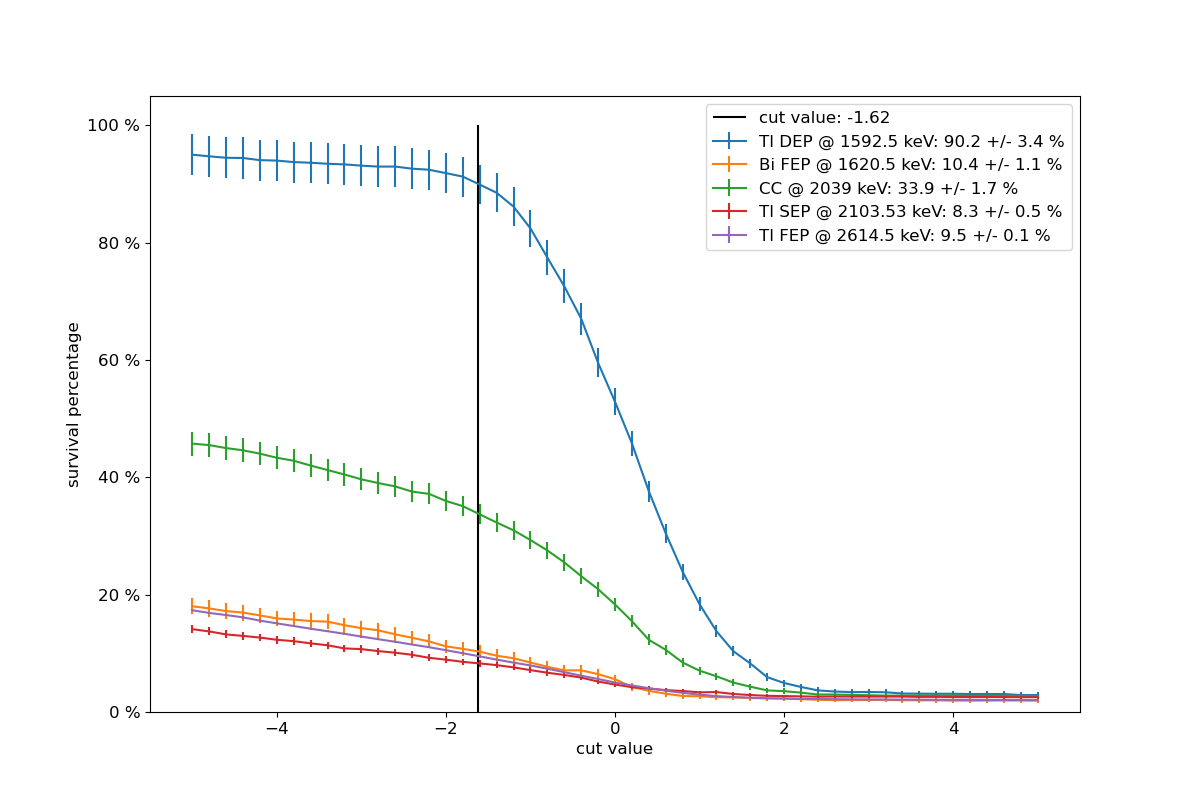

In [32]:

plot_dict["survival_fractions"]

## Taking this apart

cal_aoe consists of a number of methods which are the steps in the A/E calibration, when we call calibrate it steps through these methods 

In [33]:
help(cal_aoe)

Help on class cal_aoe in module pygama.pargen.AoE_cal:

class cal_aoe(builtins.object)
 |  cal_aoe(cal_dicts: 'dict' = {}, cal_energy_param: 'str' = 'cuspEmax_ctc_cal', eres_func: 'callable' = <function cal_aoe.<lambda> at 0x7f8ea7065670>, pdf=<class 'pygama.pargen.AoE_cal.standard_aoe'>, selection_string: 'str' = '(index==index)', dt_corr: 'bool' = False, dep_acc: 'float' = 0.9, dep_correct: 'bool' = False, dt_cut: 'dict' = None, dt_param: 'str' = 'dt_eff', high_cut_val: 'int' = 3, mean_func: 'Callable' = <class 'pygama.pargen.AoE_cal.pol1'>, sigma_func: 'Callable' = <class 'pygama.pargen.AoE_cal.sigma_fit'>, comptBands_width: 'int' = 20, plot_options: 'dict' = {})
 |  
 |  Methods defined here:
 |  
 |  AoEcorrection(self, data: 'pd.DataFrame', aoe_param: 'str', display: 'int' = 0)
 |      Calculates the corrections needed for the energy dependence of the A/E.
 |      Does this by fitting the compton continuum in slices and then applies fits to the centroid and variance.
 |  
 |  __i

### Running calibrate in steps

In [34]:
kwarg_dict = Props.read_from(meta.dataprod.config.on(iter(all_cal_files).__next__(), system="cal").snakemake_rules.pars_pht_aoecal.inputs.par_pht_aoecal_config[channel])


In [ ]:
data,
    selection_string=
    cal_dicts=cal_dict,
    eres_func=eres_func,
    pdf=pdf,
    mean_func=mean_func,
    sigma_func=sigma_func,
    **kwarg_dict,

In [35]:
kwarg_dict

{'run_aoe': True,
 'pulser_multiplicity_threshold': 5,
 'final_cut_field': 'is_valid_cal',
 'threshold': 800,
 'current_param': 'A_max',
 'energy_param': 'cuspEmax',
 'cal_energy_param': 'cuspEmax_ctc_cal',
 'dt_corr': True,
 'dt_param': 'dt_eff',
 'mean_func': 'pol1',
 'sigma_func': 'sigma_fit',
 'high_cut_val': 3,
 'plot_options': {'spectrum': {'function': 'plot_spectra', 'options': None},
  'sf_v_energy': {'function': 'plot_sf_vs_energy', 'options': None},
  'survival_fractions': {'function': 'plot_survival_fraction_curves',
   'options': None},
  'cut_fit': {'function': 'plot_cut_fit', 'options': None},
  'classifier': {'function': 'plot_classifier', 'options': None},
  'sigma_fit': {'function': 'plot_sigma_fit', 'options': None},
  'mean_fit': {'function': 'plot_mean_fit', 'options': None},
  'plot_dt_dep': {'function': 'plot_dt_dep',
   'options': {'eranges': [[1582, 1602],
     [1510, 1630],
     [2030, 2050],
     [2080, 2120],
     [2584, 2638]],
    'titles': ['Tl DEP', 'Bi F

In [38]:
aoe = cal_aoe(
        all_cal_dicts,
        "cuspEmax_ctc_cal",
        eres_func = eres_func,
        pdf = pdf,
        selection_string = f"{kwarg_dict['final_cut_field']}&(~is_pulser)",
        dt_corr = True,
        dep_acc = 0.9,
        dt_param= kwarg_dict["dt_param"],
        high_cut_val = kwarg_dict["high_cut_val"],
        mean_func = mean_func,
        sigma_func = sigma_func,
    )

In [43]:
aoe.aoe_timecorr(data, "AoE_Uncorr")
log.info("Finished A/E time correction")

INFO:pygama.pargen.AoE_cal:Starting A/E time correction
INFO:pygama.pargen.AoE_cal:A/E time correction finished
INFO:pygama.pargen.AoE_cal:Finished A/E time correction


{'20230311T235840Z': {'cuspEmax_ctc': {'expression': 'cuspEmax*(1+dt_eff*a)', 'parameters': {'a': 5.62e-07}}, 'cuspEftp_ctc': {'expression': 'cuspEftp*(1+dt_eff*a)', 'parameters': {'a': 5.62e-07}}, 'zacEmax_ctc': {'expression': 'zacEmax*(1+dt_eff*a)', 'parameters': {'a': 5.75e-07}}, 'zacEftp_ctc': {'expression': 'zacEftp*(1+dt_eff*a)', 'parameters': {'a': 5.75e-07}}, 'trapEmax_ctc': {'expression': 'trapEmax*(1+dt_eff*a)', 'parameters': {'a': 5.56e-07}}, 'trapEftp_ctc': {'expression': 'trapEftp*(1+dt_eff*a)', 'parameters': {'a': 5.56e-07}}, 'tailEmax_cut': {'expression': '(a<(tailEmax))&((tailEmax)<b)', 'parameters': {'a': 6.0739, 'b': 26.5271}}, 'baselineEmax_cut': {'expression': '(a<(baselineEmax))&((baselineEmax)<b)', 'parameters': {'a': 4.7043, 'b': 26.2753}}, 'bl_slope_cut': {'expression': '(a<(bl_slope))&((bl_slope)<b)', 'parameters': {'a': -0.0759, 'b': 0.0755}}, 'bl_std_cut': {'expression': '(a<(bl_std))&((bl_std)<b)', 'parameters': {'a': 10.0781, 'b': 14.9983}}, 'dt_eff_cut': {

In [44]:
aoe.AoEcorrection(data, "AoE_Timecorr")

INFO:pygama.pargen.AoE_cal:Starting A/E energy correction
INFO:pygama.pargen.AoE_cal:60 compton bands fit successfully
INFO:pygama.pargen.AoE_cal:Finished A/E energy successful
INFO:pygama.pargen.AoE_cal:mean pars are {'a': -3.2944298371260024e-06, 'b': 1.003829247851425}
INFO:pygama.pargen.AoE_cal:sigma pars are {'a': 3.187280844764668e-05, 'b': 23.16142169375366, 'c': 2.420421528453484}


In [45]:
aoe.get_aoe_cut_fit(data, "AoE_Classifier", 1592, (40, 20), 0.9)

INFO:pygama.pargen.AoE_cal:Starting A/E low cut determination
INFO:pygama.pargen.AoE_cal:Cut found at -1.63


Final step is to compute survival fractions for 1 side and double side.
The 1 side is done as a sweep through cut values.
This is the slowest step as many fits are being performed on large amounts of data.


In [53]:
aoe_param = "AoE_Classifier"
log.info("  Compute low side survival fractions: ")
aoe.low_side_sf = pd.DataFrame(columns=["peak", "sf", "sf_err"])
peaks_of_interest = [1592.5, 1620.5, 2039, 2103.53, 2614.50]
fit_widths = [(40, 25), (25, 40), (0, 0), (25, 40), (50, 50)]
aoe.low_side_peak_dfs = {}

for i, peak in enumerate(peaks_of_interest):
    select_df = data.query(
        f"{aoe.selection_string}&{aoe_param}=={aoe_param}"
    )
    fwhm = aoe.eres_func(peak)
    if peak == 2039:
        emin = 2 * fwhm
        emax = 2 * fwhm
        peak_df = select_df.query(
            f"({aoe.cal_energy_param}>{peak-emin})&({aoe.cal_energy_param}<{peak+emax})"
        )

        cut_df, sf, sf_err = compton_sf_sweep(
            peak_df[aoe.cal_energy_param].to_numpy(),
            peak_df[aoe_param].to_numpy(),
            aoe.low_cut_val,
            peak,
            fwhm,
            dt_mask=peak_df[aoe.dt_cut_param].to_numpy()
            if aoe.dt_cut_param is not None
            else None,
        )
        aoe.low_side_sf = pd.concat(
            [
                aoe.low_side_sf,
                pd.DataFrame([{"peak": peak, "sf": sf, "sf_err": sf_err}]),
            ]
        )
        aoe.low_side_peak_dfs[peak] = cut_df
    else:
        emin, emax = fit_widths[i]
        peak_df = select_df.query(
            f"({aoe.cal_energy_param}>{peak-emin})&({aoe.cal_energy_param}<{peak+emax})"
        )
        cut_df, sf, sf_err = get_sf_sweep(
            peak_df[aoe.cal_energy_param].to_numpy(),
            peak_df[aoe_param].to_numpy(),
            aoe.low_cut_val,
            peak,
            fwhm,
            dt_mask=peak_df[aoe.dt_cut_param].to_numpy()
            if aoe.dt_cut_param is not None
            else None,
        )
        aoe.low_side_sf = pd.concat(
            [
                aoe.low_side_sf,
                pd.DataFrame([{"peak": peak, "sf": sf, "sf_err": sf_err}]),
            ]
        )
        aoe.low_side_peak_dfs[peak] = cut_df
    log.info(f"{peak}keV: {sf:2.1f} +/- {sf_err:2.1f} %")
    aoe.low_side_sf.set_index("peak", inplace=True)
    
    
    

INFO:pygama.pargen.AoE_cal:  Compute low side survival fractions: 
INFO:pygama.pargen.AoE_cal:1592.5keV: 90.1 +/- 3.4 %
INFO:pygama.pargen.AoE_cal:1620.5keV: 10.5 +/- 1.1 %
INFO:pygama.pargen.AoE_cal:2039keV: 34.9 +/- 1.7 %
INFO:pygama.pargen.AoE_cal:2103.53keV: 8.3 +/- 0.6 %
INFO:pygama.pargen.AoE_cal:2614.5keV: 9.9 +/- 0.1 %


In [55]:
aoe.two_side_sf = pd.DataFrame(columns=["peak", "sf", "sf_err"])
log.info("Calculating 2 sided cut sfs")
for i, peak in enumerate(peaks_of_interest):
    select_df = data.query(
    f"{aoe.selection_string}&{aoe_param}=={aoe_param}"
    )
    fwhm = aoe.eres_func(peak)

    if peak == 2039:
        emin = 2 * fwhm
        emax = 2 * fwhm
        peak_df = select_df.query(
            f"({aoe.cal_energy_param}>{peak-emin})&({aoe.cal_energy_param}<{peak+emax})"
        )

        sf_dict = compton_sf(
            peak_df[aoe_param].to_numpy(),
            aoe.low_cut_val,
            aoe.high_cut_val,
            dt_mask=peak_df[aoe.dt_cut_param].to_numpy()
            if aoe.dt_cut_param is not None
            else None,
        )
        sf = sf_dict["sf"]
        sf_err = sf_dict["sf_err"]
        aoe.two_side_sf = pd.concat(
            [
                aoe.two_side_sf,
                pd.DataFrame([{"peak": peak, "sf": sf, "sf_err": sf_err}]),
            ]
        )
    else:
        emin, emax = fit_widths[i]
        peak_df = select_df.query(
            f"({aoe.cal_energy_param}>{peak-emin})&({aoe.cal_energy_param}<{peak+emax})"
        )
        sf, sf_err, _, _ = get_survival_fraction(
            peak_df[aoe.cal_energy_param].to_numpy(),
            peak_df[aoe_param].to_numpy(),
            aoe.low_cut_val,
            peak,
            fwhm,
            high_cut=aoe.high_cut_val,
            dt_mask=peak_df[aoe.dt_cut_param].to_numpy()
            if aoe.dt_cut_param is not None
            else None,
        )
        aoe.two_side_sf = pd.concat(
            [
                aoe.two_side_sf,
                pd.DataFrame([{"peak": peak, "sf": sf, "sf_err": sf_err}]),
            ]
        )
    log.info(f"{peak}keV: {sf:2.1f} +/- {sf_err:2.1f} %")
aoe.two_side_sf.set_index("peak", inplace=True)


INFO:pygama.pargen.AoE_cal:Calculating 2 sided cut sfs
INFO:pygama.pargen.AoE_cal:1592.5keV: 86.8 +/- 3.3 %
INFO:pygama.pargen.AoE_cal:1620.5keV: 8.5 +/- 1.0 %
INFO:pygama.pargen.AoE_cal:2039keV: 31.9 +/- 1.6 %
INFO:pygama.pargen.AoE_cal:2103.53keV: 5.8 +/- 0.5 %
INFO:pygama.pargen.AoE_cal:2614.5keV: 7.7 +/- 0.1 %
